### <center>**Assignment**</center>

Implement the Adaline with SGD which can set different batch_size ($M$) as parameter. Then, use the Iris dataset to fit your model with 3 different $M$ (including $M=1$) and fixed learning rate η and print out the accuracy of each model. Last, plot the cost against the number of epochs using different $M$ in one figure.

### **Requirements:**

- Submit to eeclass with your code file `Lab04-1_{student_id}.ipynb` and image file `Lab04-1_{student_id}.png` (e.g. `Lab04-1_110069999.ipynb`).
- **The code file should only contain the Assignment part.**
- You can take the model we taught in lab as reference.
- To simplfy your work, you can ignore part of data which is not divisible by M.
- Deadline: **2024-01-07 (Sun) 23:59**.

Your code file should contain:

1. Split training and testing data (test_size = 20% of the whole dataset)
2. Handcrafted Adaline classifier with M as parameter.
3. Fit model with 3 different M and fixed η. (including M=1)
4. Print the accuracy of each model.
5. Plot the cost against the number of epochs using different M in one figure.

Your image file should contain:

1. Figure of the cost against the number of epochs using different M.



In [1]:
import os, math
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from IPython.display import display
import matplotlib.pyplot as plt
seed = np.random.seed

df = pd.read_csv('https://archive.ics.uci.edu/ml/'
        'machine-learning-databases/iris/iris.data', header=None)
df.columns = ['Sepal length', 'Sepal width', 'Petal length', 'Petal width', 'Class label']
display(df.head())

X = df[['Petal length', 'Petal width']].values
y = pd.factorize(df['Class label'])[0]

# discard exmaples in the first class
X = X[50:150]
y = np.where(y[50:150] == 2, -1, y[50:150])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('# Training data points: %d' % X_train.shape[0])
print('# Testing data points: %d' % X_test.shape[0])
print('Class labels: %s' % np.unique(y))

,Sepal length,Sepal width,Petal length,Petal width,Class label
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


# Training data points: 80
# Testing data points: 20
Class labels: [-1  1]


In [19]:
class AdalineSGD(object):
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
        Learning rate (between 0.0 and 1.0)
    n_iter : int
        Passes over the training dataset.
    batch_size : int
        How many data in a mini batch.

    Attributes
    -----------
    w_ : 1d-array
        Weights after fitting.
    errors_ : list
        Number of misclassifications in every epoch.
    shuffle : bool (default: True)
        Shuffles training data every epoch if True to prevent cycles.
    random_state : int
        Set random state for shuffling and initializing the weights.

    """
    def __init__(self, eta=0.01, n_iter=50, batch_size=1, shuffle=True, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.batch_size = batch_size
        self.w_initialized = False
        self.shuffle = shuffle
        if random_state : seed(random_state)
        
    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : array-like; shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.
        y : array-like; shape = [n_samples]
            Target values or labels.

        Returns
        -------
        self : object

        """
        self._initialize_weights(X.shape[1])
        self.cost_ = []
        for i in range(self.n_iter):
            if self.shuffle:
                X, y = self._shuffle(X, y)
            # cost = []
            # for i in range(0, X.shape[0], self.batch_size):
            #     X_batch, y_batch = X[i: i+self.batch_size, :], y[i: i+self.batch_size]
            #     for xi, yi in zip(X_batch, y_batch):
            #         cost.append(self._update_weights(xi, yi))
            #     if(i % 10 == 0):
            #         avg_cost = sum(cost) / len(y_batch)
            #         self.cost_.append(avg_cost)
            #         cost = []

            steps = X.shape[0] // self.batch_size
            cost = []
            for idx in range(steps):
                start = idx * self.batch_size
                end = (idx + 1) * self.batch_size
                X_batch, y_batch = X[start: end, :], y[start: end]
                for xi, yi in zip(X_batch, y_batch):
                    cost.append(self._update_weights(xi, yi))
                # if(((idx + 1) * self.batch_size) % 20 == 0):
            avg_cost = sum(cost) / len(y)
            self.cost_.append(avg_cost)
                    # cost = []
        return self

    def _shuffle(self, X, y):
        """Shuffle training data"""
        r = np.random.permutation(len(y))
        return X[r], y[r]
    
    def _initialize_weights(self, m):
        """Randomly initialize weights"""
        self.w_ = np.random.normal(loc=0.0, scale=0.01, size=1 + m)
        self.w_initialized = True
        
    def _update_weights(self, xi, yi):
        """Apply Adaline learning rule to update the weights"""
        output = self.activation(xi)
        
        # Cost function
        error = (yi - output)
        cost = 0.5 * error**2
        
        # Update rule
        self.w_[1:] += self.eta * xi.dot(error)
        self.w_[0] += self.eta * error
        
        return cost
    
    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_[1:]) + self.w_[0]

    def activation(self, X):
        """Compute linear activation"""
        return self.net_input(X)

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(X) >= 0.0, 1, -1)

    def partial_fit(self, X, y):
        """Fit training data without reinitializing the weights"""
        if not self.w_initialized:
            self._initialize_weights(X.shape[1])
        if y.ravel().shape[0] > 1:
            for xi, yi in zip(X, y):
                self._update_weights(xi, yi)
        else:
            self._update_weights(X, y)
        return self

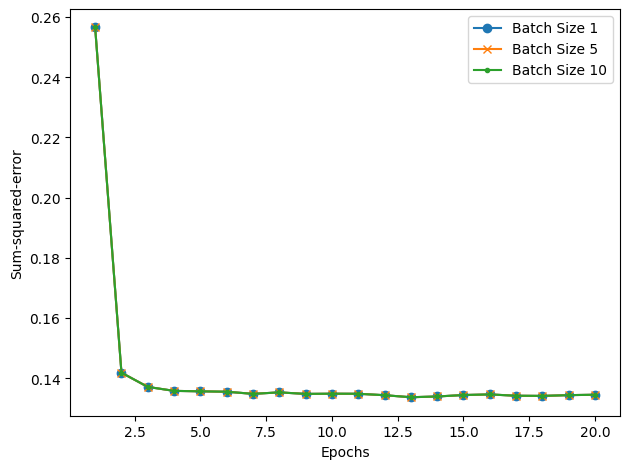

AdalineSGD with batch size 1:
Misclassified samples: 3
Accuracy: 0.85

AdalineSGD with batch size 5:
Misclassified samples: 3
Accuracy: 0.85

AdalineSGD with batch size 10:
Misclassified samples: 3
Accuracy: 0.85



In [20]:
batch_size1 = 1
batch_size2 = 5
batch_size3 = 10
adas1 = AdalineSGD(n_iter=20, eta=0.01, batch_size=batch_size1, random_state=1)
adas1.fit(X_train_std, y_train)
adas2 = AdalineSGD(n_iter=20, eta=0.01, batch_size=batch_size2, random_state=1)
adas2.fit(X_train_std, y_train)
adas3 = AdalineSGD(n_iter=20, eta=0.01, batch_size=batch_size3, random_state=1)
adas3.fit(X_train_std, y_train)

# Cost values
plt.plot(range(1, len(adas1.cost_) + 1), adas1.cost_, 
         marker='o', label='Batch Size 1')
plt.plot(range(1, len(adas2.cost_) + 1), adas2.cost_, 
         marker='x', label='Batch Size 5')
plt.plot(range(1, len(adas3.cost_) + 1), adas3.cost_, 
         marker='.', label='Batch Size 10')
plt.xlabel('Epochs')
plt.ylabel('Sum-squared-error')
plt.legend(loc='upper right')

plt.tight_layout()
plt.savefig('./output/fig-adaline-sgd-cost.png', dpi=300)
plt.show()

# Testing accuracy
y_pred = adas1.predict(X_test_std)
print("AdalineSGD with batch size 1:")
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f\n' % accuracy_score(y_test, y_pred))

y_pred = adas2.predict(X_test_std)
print("AdalineSGD with batch size 5:")
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f\n' % accuracy_score(y_test, y_pred))

y_pred = adas3.predict(X_test_std)
print("AdalineSGD with batch size 10:")
print('Misclassified samples: %d' % (y_test != y_pred).sum())
print('Accuracy: %.2f\n' % accuracy_score(y_test, y_pred))